In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from weather_mcmc import mcmc_analysis, plot_transition_matrices, plot_loc_stationary_distributions, plot_generated_chains, analyse_chains



In [2]:
bristol = pd.read_csv("data/bristol_weather_winter.csv")
rey = pd.read_csv("data/reykjavik_weather_winter.csv")
losang = pd.read_csv("data/la_weather_winter.csv")
#store the dataframes in a dictionary for easy access later
loc_dfs = {"Bristol": bristol, "Reykjavic":rey, "Los Angeles": losang}

bristol.head() 


,time,city,icon,summary,precipIntensity,precipAccumulation,precipType,temperature,apparentTemperature,dewPoint,pressure,windSpeed,windGust,windBearing,cloudCover,snowAccumulation
0,2022-11-01 00:00:00+00:00,bristol,rain,Rain,0.69,0.0686,rain,12.64,14.58,11.37,995.70,5.49,15.59,215.48,1.00,0.0
1,2022-11-01 01:00:00+00:00,bristol,rain,Rain,1.66,0.1655,rain,12.34,14.26,11.34,996.71,7.71,22.16,247.17,1.00,0.0
2,2022-11-01 02:00:00+00:00,bristol,rain,Rain,0.36,0.0365,rain,12.03,13.50,10.39,998.93,11.49,20.51,247.84,1.00,0.0
3,2022-11-01 03:00:00+00:00,bristol,cloudy,Cloudy,0.00,0.0000,none,11.92,12.60,8.65,1001.10,11.32,15.59,246.61,1.00,0.0
4,2022-11-01 04:00:00+00:00,bristol,cloudy,Cloudy,0.01,0.0005,rain,12.05,12.85,8.93,1002.28,8.47,13.99,240.20,0.93,0.0


#### Test case 1: Comparison between locations


What this section compares (for the weather summary data, and the precipitation type data): 
- the transition probability matrices obtained from the measured data, for each location
- the stationary distributions for each location (from measured data)



In [3]:
nr_antecedents = 1 #the number of samples in the sequence that are used to compute the transition probabilities. 1 is a 1st order chain etc..
num_samples = 100 #the number of samples to have generated in total
num_repeats = 10 #the number of chains generated (though multiple used in Test case 2)

#Get MCMC results for various data columns, for all locations. 
results = {} #Each column has a dictionary entry, an each column has a further nested dictionary storing the location results
for col in [ "summary", "precipType", "temperature"]:
    loc_trans_matrices, stat_distributions, loc_generated_freqs, loc_generated_chains,  loc_states= mcmc_analysis(loc_dfs, col, nr_antecedents, num_repeats, num_samples)
    results[col]  = loc_trans_matrices, stat_distributions, loc_generated_freqs, loc_generated_chains, loc_states
    


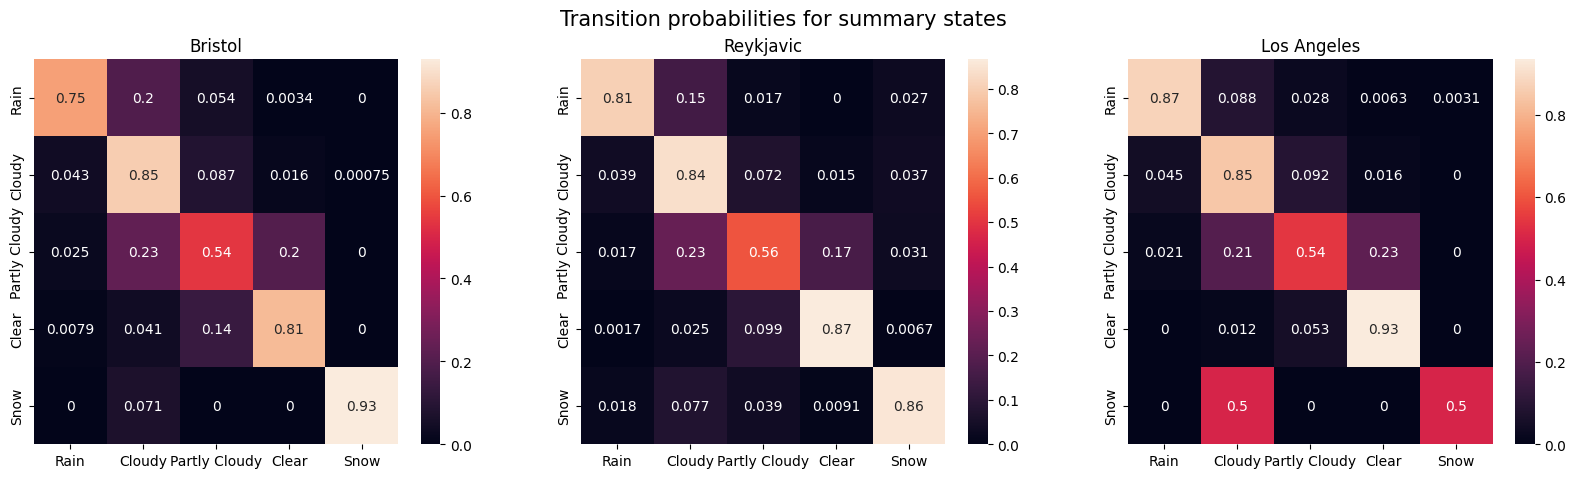

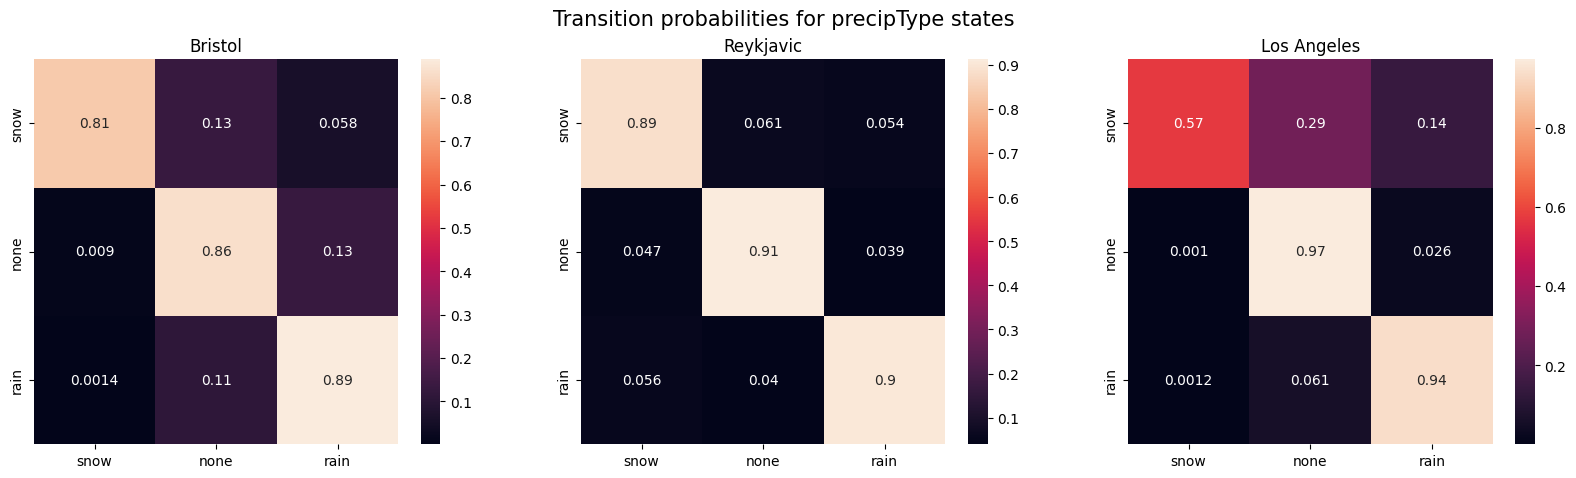

In [4]:


for col in ["summary", "precipType"]:
    plot_transition_matrices(results[col][0], column = col)


##### The stationary distributions

**A note on irreducible chains and stationary distributions**: 

(Information gotten (http://www.stat.yale.edu/~pollard/Courses/251.spring2013/Handouts/Chang-MarkovChains.pdf))

If a Markov Chain is irreducible, it has a stationary distribution - this means that there is a long-term probability of states which will (in the long term) remain constant.

Checking for irreducibility amounts to showing that one can get from any state to any other given state in a finite number of steps. 
So, for example, the probability of going from Clear to Snow is 0, but Clear can get to Snow via becoming CLoudy first and then transitioning from Cloudy to Snowy (and thus they're connected), etc.

One way of checking for irreducibility is by raising the transition proabbility matrix to some power n - if all entries are positive (non-zero) after taking mutiple powers of the matrix, then it is irreducible. 

- Calculating the stationary distribution:

    The stationary distribution pi has to satisfy: 
    $$ \pi = P\pi $$  
    and the elements of pi need to sum to 1 (normalization constraint), as (). 
    This leads to a linear system of equations which needs to be solved: $ (P^T - I)\pi = 0 $ (under the normalization constraint)


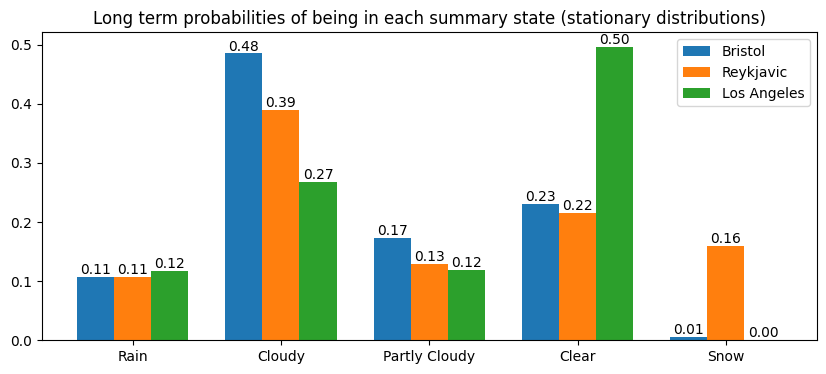

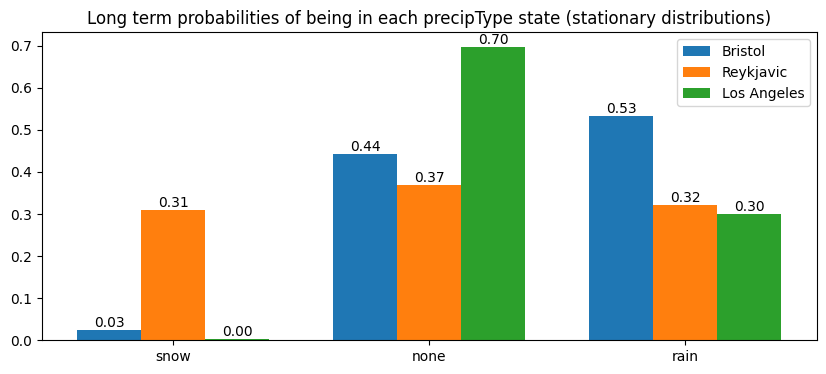

In [5]:
for col in ["summary","precipType"]:
    plot_loc_stationary_distributions(results[col][1], column=col)

**Long term behaviour**: 

These results show that in the case of Bristol, the weather state will be predominantly cloudy in the long term- specifically, for 48% of the times, and will only be Clear for a bit under a quarter of the times (which is expected, being UK weather). 
Looking at the values for the Precipitation type, the amount of time spent in the "Rain" type is a lot higher than the Rain state observed above - this could possibly be explained with some instances of Rain not occuring for the whole hour (or very low, possibly). The important thing to note here, however, is that it rains a lot in Bristol (it can be expected 53% of the times.)

Reykjavic will be found to be CLoudy less times (39%), but this is also the predominant state in this location. Out of the three locations, it will spend the most amount of time in a state of Snow - 16% of the times compared to the near zero or zero probabities for Bristol and LA, respectively. This makes sense given its very nothern location.

Those living in LA can expect it to be Clear an impressive 50% of times, spending the least time out of all locations in the Cloudy state (27%.)

According to the Precipitation data, Reykjavic and LA can expect rain almost the same amount of times, with 70% of the time in LA being dry, however. According to this data, Reykjavic can also expect it to snow 31% of the times, again presenting a difference to the above states values which could be due to some data-taking errors or unclear definitions. 

##### Visualising the Markov chains

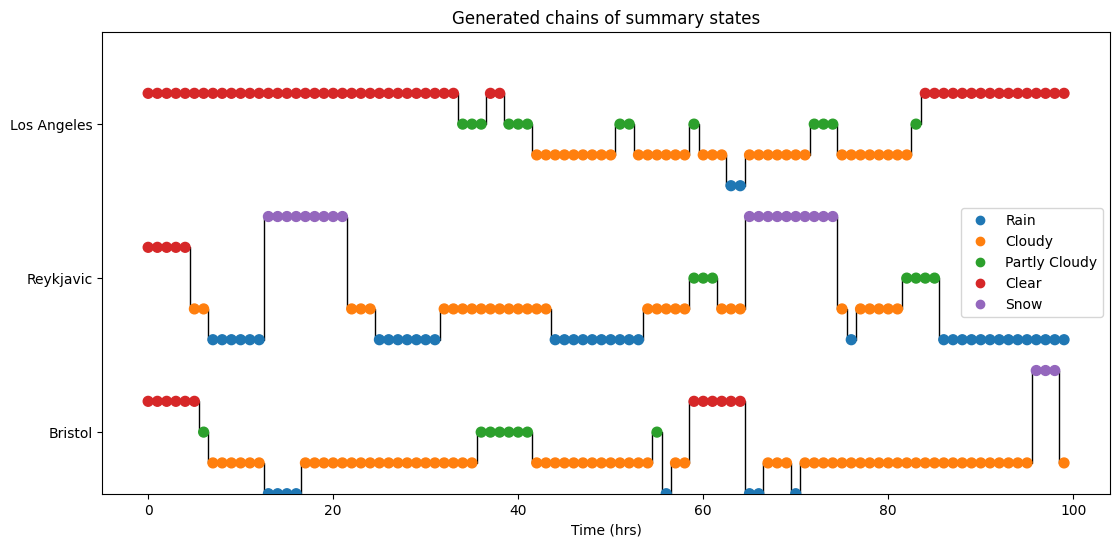

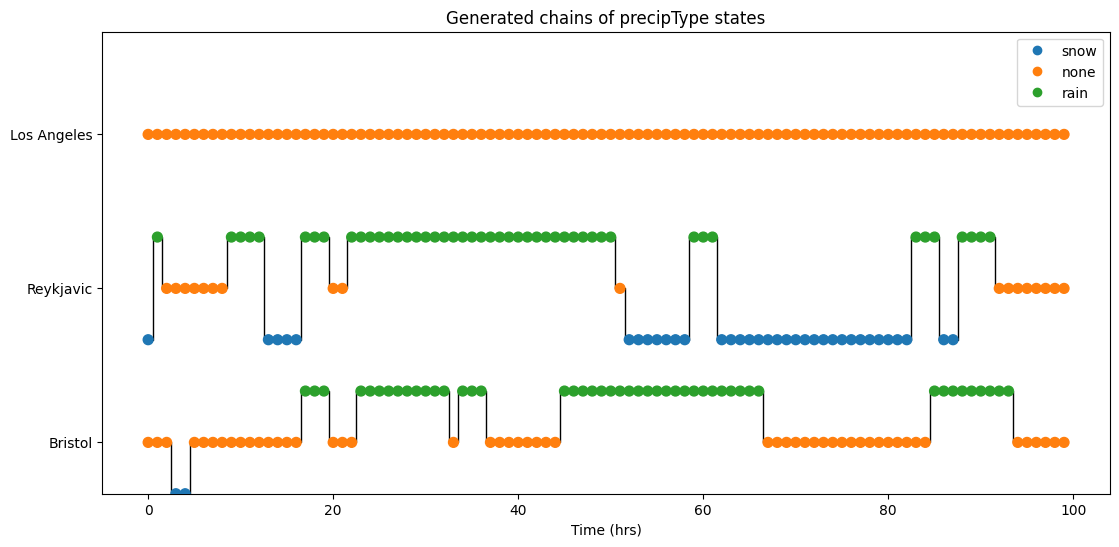

Maximum consecutive appearances of each summary state: 


,Rain,Cloudy,Partly Cloudy,Clear,Snow
Bristol,4.0,25.0,6.0,6.0,3.0
Reykjavic,14.0,12.0,4.0,5.0,10.0
Los Angeles,2.0,9.0,3.0,34.0,0.0


In [6]:

plot_generated_chains(loc_dfs.keys(), results, "summary")
plot_generated_chains(loc_dfs.keys(), results, "precipType")

consecs = []
for loc in loc_dfs.keys():
    states = results["summary"][-1][loc]
    means, std_devs, state_consecs = analyse_chains(results["summary"][-2][loc],states)
    consecs.append(state_consecs[0])

print("Maximum consecutive appearances of each summary state: ")
pd.DataFrame(consecs, columns = states, index = loc_dfs.keys()) 




As can be seen in the generated chains of the summary states, in this particular instance Los Angeles has the highest number of consecutives states (thisi being in the Clear condition, as expected. ). 
Bristol and Reykjavic's states both fluctuate a lot more as can be seen in the plot, with Reykjavic having the longest streak of rainy hours, and Bristol the longest streak of Cloudy hours. 

However, this shows only one chain for each location - a better picture is given when multiple chains are analysed as below.

#### Test Case 2

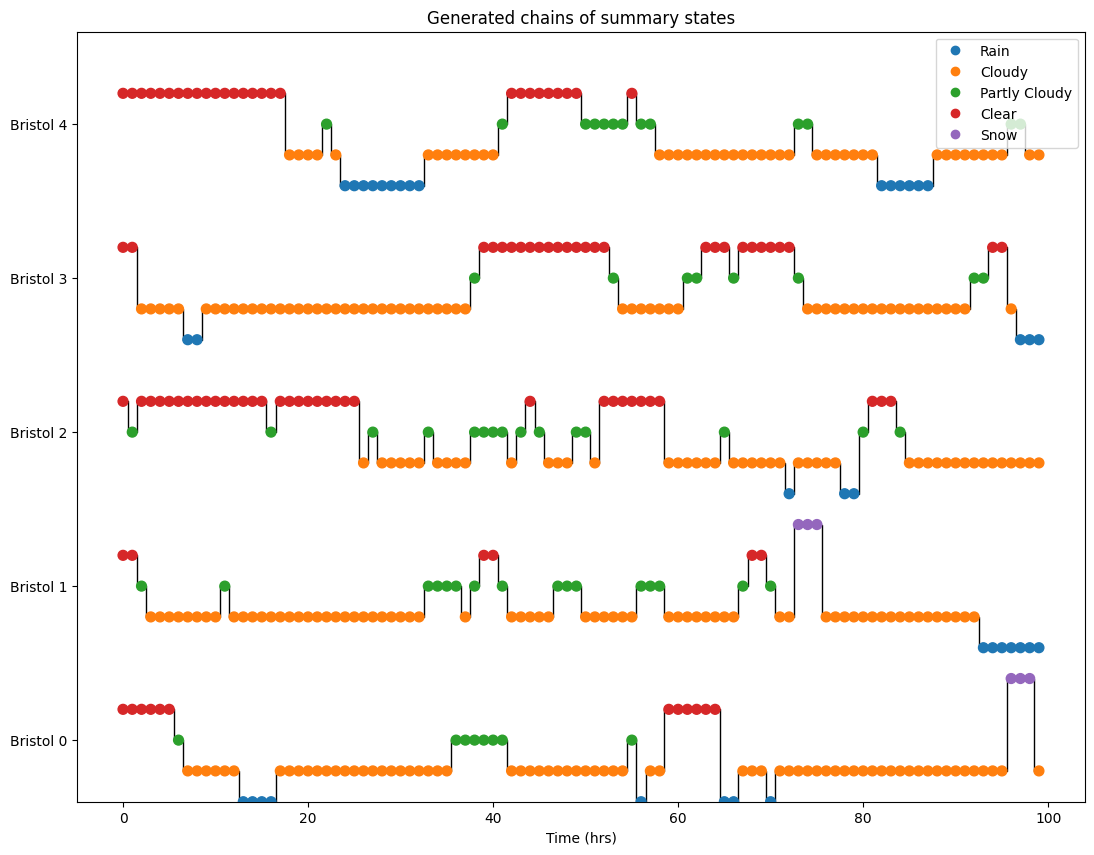

Maximum consecutive appearances of each summary state of Bristol, for 5 runs: 


,Rain,Cloudy,Partly Cloudy,Clear,Snow
0,4.0,25.0,6.0,6.0,3.0
1,7.0,21.0,4.0,2.0,3.0
2,2.0,15.0,4.0,14.0,0.0
3,3.0,29.0,2.0,14.0,0.0
4,9.0,15.0,5.0,18.0,0.0


In [7]:

#Visualise 5 chains for the Bristol summary data:
plot_generated_chains(["Bristol"]*5, results, "summary", repeat_loc=True)

states = results["summary"][-1]["Bristol"]
means, std_devs, state_consecs = analyse_chains(results["summary"][-2]["Bristol"],states)

print("Maximum consecutive appearances of each summary state of Bristol, for 5 runs: ")
pd.DataFrame(state_consecs[:5], columns = states)

This shows how much the chains can vary across iterations of the same model - with the streak of time spent being Cloudy varying from 15 to 29, for example, and their sequential orders being very different. 

The generated-state frequencies, as well as the mean values and standard deviation for data that was originally continuous give a good overview of how "good" or reliable the generated sequences are:

##### Evaluating the generated chains

**1. Do they capture the long term behaviour?**


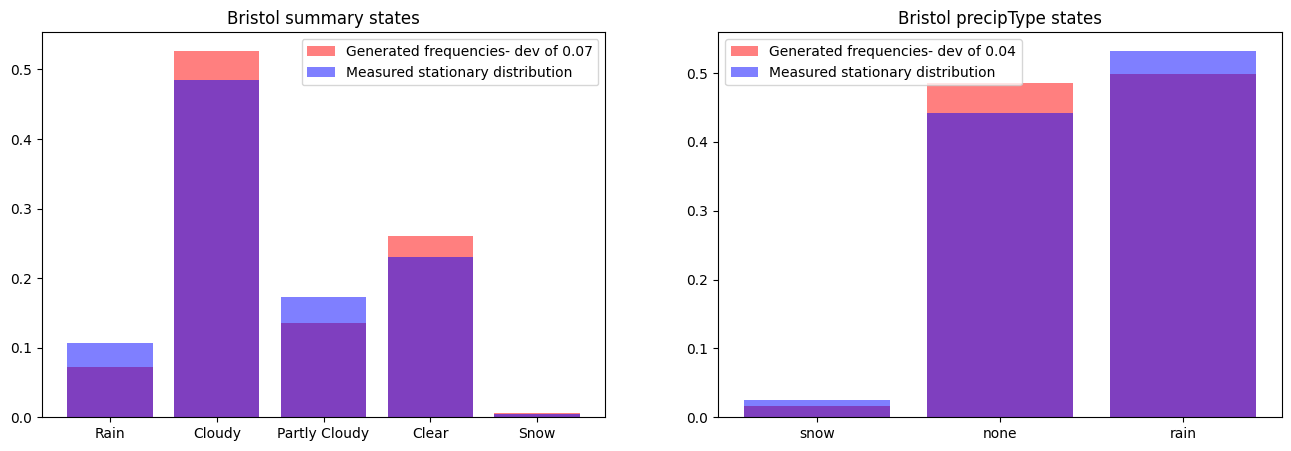

In [8]:


loc = "Bristol"
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
for i, col in enumerate(["summary", "precipType"]):
    stat_distribution = results[col][1][loc]

    #Use the mean over various all chain-runs
    chain_freqs =  results[col][2][loc]
    mean_freqs = np.mean(chain_freqs, axis = 0)

    #measure of difference: total variation distance
    tvd = 0.5 * np.sum(np.abs(mean_freqs- np.array(list(stat_distribution.values()))))

    x = results[col][-1][loc]
    axes[i].bar(x, mean_freqs, alpha = 0.5, label = f"Generated frequencies- dev of {tvd:.2f}", color = "red")
    axes[i].bar(x, stat_distribution.values(), alpha = 0.5, label = "Measured stationary distribution", color = "blue")
    axes[i].legend()
    axes[i].set_title(f"{loc} {col} states")



Comparing the generated state frequencies with the stationary distributions shows that they are quite similar for both the summary and the precipitation data, with a total variation distance (TVD) of 0.07 and 0.04 respectively - whereby the TVD ranges from 0 to 1 with 0 representing identical distributions. 

This means that chains of 100 samples converge close enough to the stationary distribution.

##### Scalability:

Increasing the number of unique states: 
- Calculating the transition matrix: Has only one for loop - this means it would scale as O(n), with n being the size of the input. This would also increase the sparsity of the matrix and lead to higher memory-usage.
- Generating the chain also only has one for-loop - so again, this would scale as O(n)
- Calculating the stationary distribution: Likely to increase computational time by a lot, as solving very large linear systems of equations is very time-consuming. 



##### Further analysis

- To further evaluate generated chains, especially when wanting to compare their reliability with the order of the chain (i.e., how many samples are used to predict the probabilities) as I had envisioned, 
one could calulcate the autocorrelation curves of the chains and compare them to the autocorrelation function of the measured sequence. 

An example of this appears in following paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6303304

